In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import regionmask
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Import our data

#### Import GC output

In [12]:
GC_new = xr.open_dataset('../../GCrundirs/test_NEI_jan_CNO2/geosfp_4x5_standard/OutputDir/GEOSChem.SpeciesConc.20160101_0000z.nc4') #dataset with the kgC/m2/s and kgNO2/m2/s
GC_orig = xr.open_dataset('../../GCrundirs/test_NEI_jan_orig2011NEI/geosfp_4x5_standard/output_2013/GEOSChem.SpeciesConc.20160101_0000z.nc4') #2013 scaled NEI

datasets = [GC_new,
            GC_orig]

#combine the two datasets
GC_ds = xr.concat(datasets, pd.Index(['new','orig'], name='name')) #concat our two datasets
GC_ds*=1e9 #convert to ppb

#sum our NO and NO2
GC_ds['NOx'] = GC_ds['SpeciesConc_NO'] + GC_ds['SpeciesConc_NO2']

#### Import HEMCO diagnostics

In [14]:
HEMCO_new = xr.open_dataset('../../GCrundirs/test_NEI_jan_CNO2/geosfp_4x5_standard/OutputDir/HEMCO_diagnostics.201601010000.nc')
HEMCO_old = xr.open_dataset('../../GCrundirs/test_NEI_jan_orig2011NEI/geosfp_4x5_standard/output_2013/HEMCO_diagnostics.201601010000.nc')

datasets = [HEMCO_new,
           HEMCO_old]

#combine the two datasets
HEMCO_ds = xr.concat(datasets, pd.Index(['new','orig'], name='name')) #concat our two datasets

#sum our NO and NO2
#HEMCO_ds['NOx'] = HEMCO_ds['EmisNO_Total'] + HEMCO_ds['EmisNO2_Anthro']

## Plot the NOx for each GC run

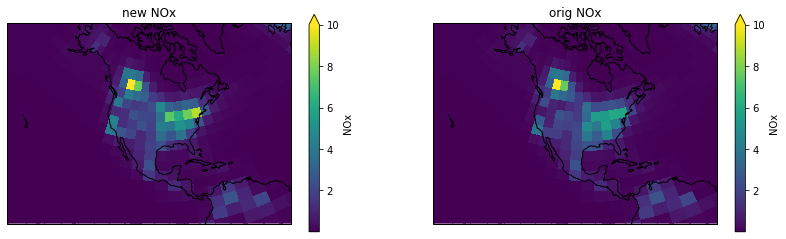

In [16]:
#### plot our NO2 for each dataset ####

fig, axes = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})

for idx, nm in enumerate(GC_ds['name'].values):
    ax = axes[idx]
    GC_ds['NOx'].isel(lev = 0).sel(name = nm).plot(ax=ax, #set the axis
                                       extend='max',#extend the colorbar in both directions
                                       transform=ccrs.PlateCarree(), #fit data into map
                                        cmap='viridis',
                                        vmax = 10)
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'{nm} NOx')


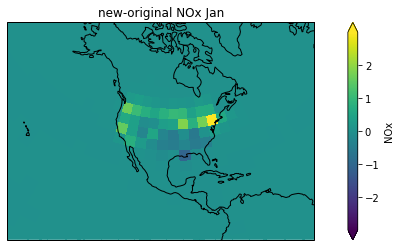

In [17]:
#### plot the difference in NO2 for our original and new files ####

fig, ax = plt.subplots(figsize = [12,4], subplot_kw={'projection':ccrs.LambertConformal()})
(GC_ds['NOx'].isel(lev = 0).sel(name = 'new') - 
 GC_ds['NOx'].isel(lev = 0).sel(name = 'orig')).plot(ax=ax, #set the axis
                                   extend='both',#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap='viridis')
ax.coastlines()
ax.set_extent([-150, -50, 0, 70])
ax.set_title(f'{nm} NOx');
plt.title('new-original NOx Jan');


## Mask our datasets to just the contiguous US

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


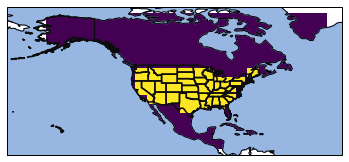

In [18]:
states = regionmask.defined_regions.natural_earth.us_states_50

# create a grid
lon = np.arange(-160, -35, 5)
lat = np.arange(14,74, 4)
# create a mask
mask = states.mask(lon, lat)
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#plot our mask
states.plot(add_label=False);
contiguous_mask.plot(add_colorbar=False)


#mask our dataset
GC_US_ds = GC_ds.where(contiguous_mask)
HEMCO_US_ds = HEMCO_ds.where(contiguous_mask)

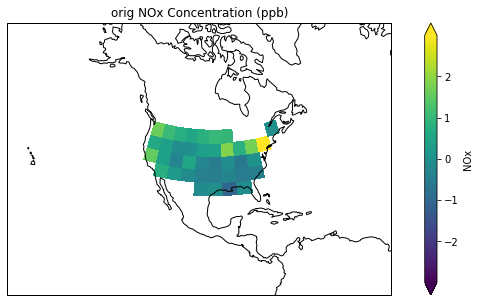

In [42]:
#### plot the difference in NO2 for our original and new files ####

fig, ax = plt.subplots(figsize = [12,5], subplot_kw={'projection':ccrs.LambertConformal()})
(GC_US_ds['NOx'].isel(lev = 0).sel(name = 'new') - 
 GC_US_ds['NOx'].isel(lev = 0).sel(name = 'orig')).plot(ax=ax, #set the axis
                                   extend='both',#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap='viridis')
ax.coastlines()
ax.set_extent([-150, -50, 0, 70])
ax.set_title(f'{nm} NOx Concentration (ppb)');

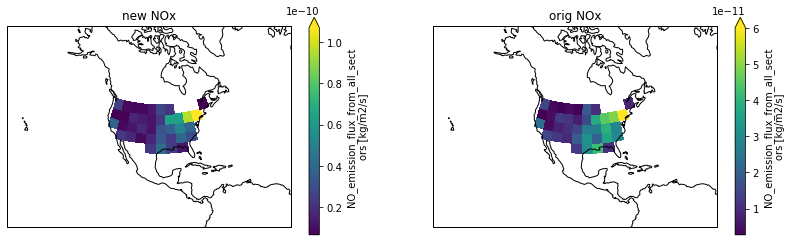

In [47]:
#### plot our NOx of HEMCO Emissions ####

fig, axes = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})

for idx, nm in enumerate(GC_ds['name'].values):
    ax = axes[idx]
    HEMCO_US_ds['EmisNO_Total'].isel(lev = 0).sel(name = nm).plot(ax=ax, #set the axis
                                       extend='max',#extend the colorbar in both directions
                                       transform=ccrs.PlateCarree(), #fit data into map
                                        cmap='viridis')
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'{nm} NOx')


#### NO2 concentrations in our GEOS Chem output

In [34]:
NOx_conc_orig = (GC_US_ds['NOx'].sel(name = 'orig')).mean().values.item()
NOx_conc_new = (GC_US_ds['NOx'].sel(name = 'new')).mean().values.item()

In [35]:
print(NOx_conc_new)
print(NOx_conc_orig)

2.9520204067230225
2.939065456390381


#### NO2 concentrations in our HEMCO diagnostics output

In [38]:
m2_s = HEMCO_US_ds['AREA'] * 60 * 60 * 24 * 31

NOx_conc_orig = (HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'orig')*m2_s +
                HEMCO_US_ds['EmisNO_Ship'].sel(name = 'orig')*m2_s +
                HEMCO_US_ds['EmisNO_Aircraft'].sel(name = 'orig')*m2_s +
                HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'orig')*m2_s +
                HEMCO_US_ds['EmisNO2_Ship'].sel(name = 'orig')*m2_s).sum().values.item()

NOx_conc_new = (HEMCO_US_ds['EmisNO_Anthro'].sel(name = 'new')*m2_s +
                HEMCO_US_ds['EmisNO_Ship'].sel(name = 'new')*m2_s +
                HEMCO_US_ds['EmisNO_Aircraft'].sel(name = 'new')*m2_s +
                HEMCO_US_ds['EmisNO2_Anthro'].sel(name = 'new')*m2_s +
                HEMCO_US_ds['EmisNO2_Ship'].sel(name = 'new')*m2_s).sum().values.item()


In [41]:
print(NO2_conc_orig, 'kg NOx from new NEI')
print(NO2_conc_new, 'kg NOx from old NEI')

1053080007.3620673 kg NOx from new NEI
1159340629.4156818 kg NOx from old NEI
